In [1]:
from openeye.oechem import *
from openeye.oedepict import *
import os
import oenotebook as oenb
from IPython.display import display, Image
ifname = "./targets.ism"
smile = "COC"

In [2]:
def ReturnSimilarities(ifname,smile):
    ifs = oemolistream()
    if not ifs.open(ifname):
        print("Cannot open target input file!")
    if isinstance(smile, str):
    #if the user inputs more than one molecule, I may need to add a loop here        
        qmol = OEGraphMol()
        OEParseSmiles(qmol, smile)
        qnames = []
        qnames.append(qmol)
        oenb.draw_mol(qmol)
        # setup depiction options  
        width = 400.0
        height = 400.0
        opts = OE2DMolDisplayOptions(width, height, OEScale_AutoScale)
        image = OEImage(width, height)
        colors = OEGetContrastColors()
        highlight = OEHighlightOverlayByBallAndStick(colors)


    # read and initialize MDL queries
        queries, subsearches = GetSubstructureSearches(qnames)
        OEThrow.Info("Number of queries %d" % len(queries))

    # import molecules

        mollist = []
        for mol in ifs.GetOEGraphMols():
            for ss in subsearches:
                OEPrepareSearch(mol, ss)
            mollist.append(OEGraphMol(mol))    
        DepictMoleculesWithSubstructureMatches(image, mollist, subsearches, opts, colors)
        DepictQueries(image, queries, colors)
 
       
    else:
        print("Please input molecule in smile format")

def CreateMolDatabaseIndexFile(ifname):
    idxfname = OEGetMolDatabaseIdxFileName(ifname)

    if os.path.exists(idxfname):
        OEThrow.Warning("%s index file already exists" % idxfname)
    elif not OECreateMolDatabaseIdx(ifname):
        OEThrow.Warning("Unable to create %s molecule index file", idxfname)
CreateMolDatabaseIndexFile(ifname)


def DepictMoleculesWithSubstructureMatches(image, mollist, subsearches, opts, colors):

    highlight = OEHighlightOverlayByBallAndStick(colors)
    borderpen = OEPen(OEWhite, OELightGrey, OEFill_Off, 1.0)
    count = 0
    for mol in mollist:

        matches = GetSubstructureMatches(subsearches, mol)
        if len(matches) == 0:  # at least one substructure search fails
            continue 
        count = count + 1
        OEPrepareDepiction(mol)
        disp = OE2DMolDisplay(mol, opts)
        OEAddHighlightOverlay(disp, highlight, matches)
        OERenderMolecule(image, disp)
        OEDrawBorder(image, borderpen)
        display(oenb.draw_oeimage(image))
    print("The number of matching molecules is: "+ str(count))
    nomatch = (len(mollist) - count)
    print("The number of nonmatching molecules is: "+ str(nomatch))

def DepictQueries(image, queries, colors):
        cellwidth, cellheight = 200.0,200.0
        opts = OE2DMolDisplayOptions(cellwidth, cellheight, OEScale_AutoScale)
        colors.ToFirst()
        for query, color in zip(queries, colors):
            disp = OE2DMolDisplay(query, opts)
            OERenderMolecule(image, disp)
            OEDrawBorder(image, OEPen(OEWhite, color, OEFill_Off, 4.0))


def GetSubstructureSearch(querymol):

    
    OEPrepareDepiction(querymol)
    qmol = OEQMol()
    queryopts = OEMDLQueryOpts_Default | OEMDLQueryOpts_SuppressExplicitH
    OEBuildMDLQueryExpressions(qmol, querymol, queryopts)

    subsearch = OESubSearch()
    if not subsearch.Init(qmol):
        OEThrow.Fatal("Cannot initialize substructure search!")
    subsearch.SetMaxMatches(1)

    return (querymol, subsearch)


def GetSubstructureSearches(qnames):

    querymols = []
    subsearches = []

    for queryfname in qnames:
        querymol, subsearch = GetSubstructureSearch(queryfname)
        querymols.append(OEGraphMol(querymol))
        subsearches.append(OESubSearch(subsearch))

    return querymols, subsearches


def GetSubstructureMatches(subsearches, mol):

    unique = True
    matches = []
    for ss in subsearches:
        miter = ss.Match(mol, unique)
        if not miter.IsValid():
            return []
        else:
            match = miter.Target()
            matches.append(OEAtomBondSet(match.GetTargetAtoms(), match.GetTargetBonds()))

    return matches

Number of queries 1


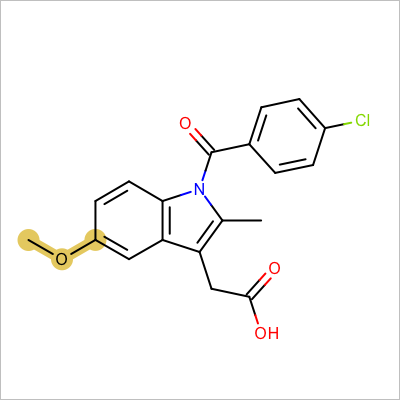

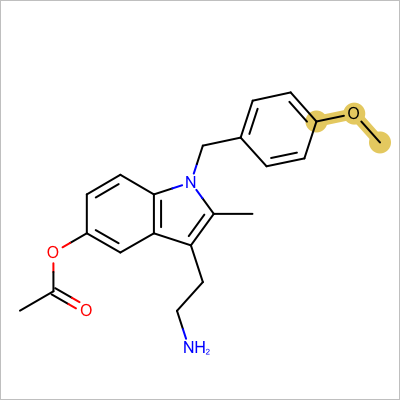

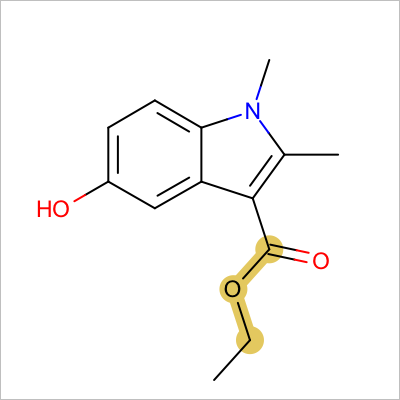

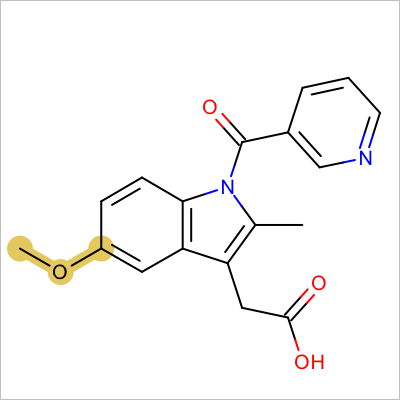

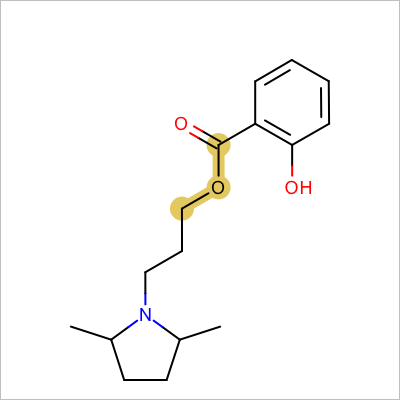

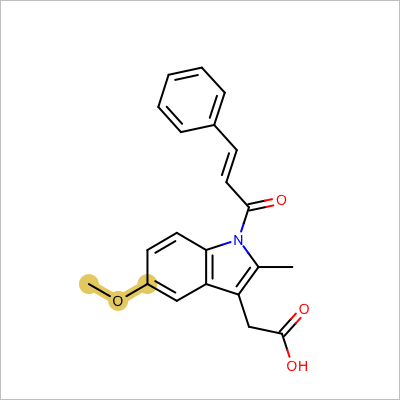

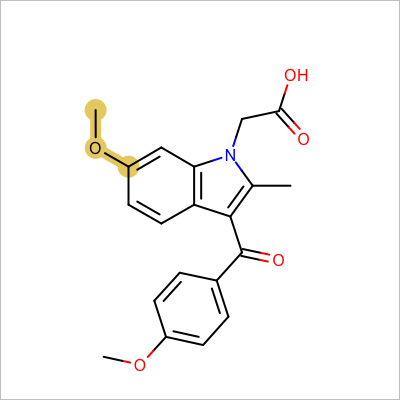

The number of matching molecules is: 7
The number of nonmatching molecules is: 5


In [3]:
ReturnSimilarities(ifname,smile)